In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.metric.metric import NormStability, NSbuilder, Stability, ProgressiveError
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.kernel.sqrt import UnarySqrt
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time
import math
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [4]:
def test(
    rng="Sobol", 
    total_cnt=100, 
    mode="unipolar", 
    bitwidth=8, 
    threshold=0.05
):
    ns_val=[0.25, 0.5, 1]
    stype = torch.float
    rtype = torch.float
    
    pbar = tqdm(total=3*total_cnt*(2**bitwidth))
    if mode is "unipolar":
        # all values in unipolar are non-negative
        low_bound = 0
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        # values in bipolar are arbitrarily positive or negative
        low_bound = -2**(bitwidth-1)
        up_bound = 2**(bitwidth-1)

    # input0 is dividend
    input = []
    for val in range(up_bound, low_bound-1, -1):
        input.append(val)

    input = torch.tensor(input, dtype=torch.float).div(up_bound).to(device)
    output = torch.sqrt(input).to(device)
    
    for ns in ns_val:
        print("# # # # # # # # # # # # # # # # # #")
        print("Target normstab:", ns)
        print("# # # # # # # # # # # # # # # # # #")

        result_ns_total = []
        input_ns_total = []
        output_ns_total = []

        for rand_idx in range(1, total_cnt+1):
            outputNS = NormStability(output, mode=mode, threshold=threshold).to(device)

            inputNS = NormStability(input, mode=mode, threshold=threshold).to(device)

            dut = UnarySqrt(mode=mode, 
                            jk_trace=False, 
                            depth_kernel=1, 
                            rng="Sobol", 
                            rng_dim=4, 
                            emit=False, 
                            depth_sr=2, 
                            stype=torch.float).to(device)

            inputBSGen = NSbuilder(bitwidth=bitwidth, 
                                    mode=mode, 
                                    normstability=ns, 
                                    threshold=threshold, 
                                    value=input, 
                                    rng_dim=rand_idx).to(device)

            start_time = time.time()
            with torch.no_grad():
                for i in range(2**bitwidth):
                    input_bs = inputBSGen()
                    inputNS.Monitor(input_bs)

                    output_bs = dut(input_bs)
                    outputNS.Monitor(output_bs)
                    pbar.update(1)

            # get the result for different rng
            input_ns = inputNS()
            output_ns = outputNS()
    
            result_ns = (output_ns/input_ns).clamp(0, 1).cpu().numpy()
            result_ns_total.append(result_ns)
            input_ns = input_ns.cpu().numpy()
            input_ns_total.append(input_ns)
            output_ns = output_ns.cpu().numpy()
            output_ns_total.append(output_ns)
            # print("--- %s seconds ---" % (time.time() - start_time))

        # get the result for different rng
        result_ns_total = np.array(result_ns_total)
        input_ns_total = np.array(input_ns_total)
        output_ns_total = np.array(output_ns_total)
        #######################################################################
        # check the error of all simulation
        #######################################################################
        print("avg I NS:{:1.4}".format(np.mean(input_ns_total)))
        print("max I NS:{:1.4}".format(np.max(input_ns_total)))
        print("min I NS:{:1.4}".format(np.min(input_ns_total)))
        print()
        print("avg O NS:{:1.4}".format(np.mean(output_ns_total)))
        print("max O NS:{:1.4}".format(np.max(output_ns_total)))
        print("min O NS:{:1.4}".format(np.min(output_ns_total)))
        print()
        print("avg O/I NS:{:1.4}".format(np.mean(result_ns_total)))
        print("max O/I NS:{:1.4}".format(np.max(result_ns_total)))
        print("min O/I NS:{:1.4}".format(np.min(result_ns_total)))
        print()

        #######################################################################
        # check the error according to input value
        #######################################################################
        max_total = np.max(result_ns_total, axis=0)
        min_total = np.min(result_ns_total, axis=0)
        avg_total = np.mean(result_ns_total, axis=0)

        axis_len = outputNS().size()[0]
        input_x_axis = []
        for axis_index in range(axis_len):
            input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
        fig, ax = plt.subplots()
        ax.fill_between(input_x_axis, max_total, avg_total, facecolor="red", alpha=0.75)
        ax.fill_between(input_x_axis, avg_total, min_total, facecolor="blue", alpha=0.75)
        ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)

        plt.tight_layout()
        plt.xlabel('Input value')
        plt.ylabel('Output/Input NS')
        plt.xticks(np.arange(0, 1.1, step=0.5))
        # ax.xaxis.set_ticklabels([])
        plt.xlim(0, 1)
        plt.yticks(np.arange(0, 1.1, step=0.2))
        # ax.yaxis.set_ticklabels([])
        plt.ylim(0, 1.1)
        plt.grid(b=True, which="both", axis="y", linestyle="--", color="grey", linewidth=0.3)
        fig.set_size_inches(4, 4)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        plt.show()
        plt.close()
    pbar.close()

  0%|          | 0/76800 [00:00<?, ?it/s]

# # # # # # # # # # # # # # # # # #
Target normstab: 0.25
# # # # # # # # # # # # # # # # # #


 33%|███▎      | 25533/76800 [00:26<00:52, 982.98it/s] 

avg I NS:0.3041
max I NS:1.0
min I NS:0.1797

avg O NS:0.3142
max O NS:1.0
min O NS:0.0

avg O/I NS:0.3946
max O/I NS:1.0
min O/I NS:0.0



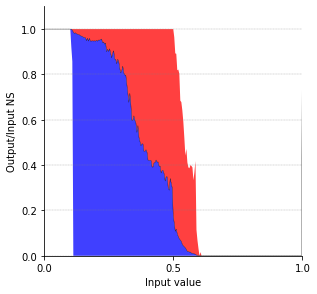

# # # # # # # # # # # # # # # # # #
Target normstab: 0.5
# # # # # # # # # # # # # # # # # #


 67%|██████▋   | 51158/76800 [00:52<00:26, 983.12it/s] 

avg I NS:0.5033
max I NS:1.0
min I NS:0.3516

avg O NS:0.326
max O NS:1.0
min O NS:0.0

avg O/I NS:0.3968
max O/I NS:1.0
min O/I NS:0.0



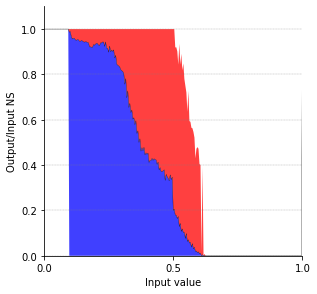

# # # # # # # # # # # # # # # # # #
Target normstab: 1
# # # # # # # # # # # # # # # # # #


100%|█████████▉| 76695/76800 [01:16<00:00, 1238.19it/s]

avg I NS:0.9466
max I NS:1.0
min I NS:0.8203

avg O NS:0.3473
max O NS:1.0
min O NS:0.0

avg O/I NS:0.3611
max O/I NS:1.0
min O/I NS:0.0



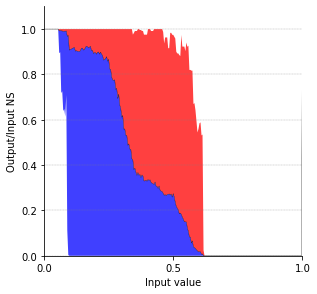

100%|██████████| 76800/76800 [01:16<00:00, 998.76it/s] 


In [5]:
test(rng="Sobol", total_cnt=100, mode="unipolar", bitwidth=8, threshold=0.05)